## **IMPORT PACKAGES**

In [2]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import os
#VISUALIZATION
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## **READING RAW DATA FROM CSV FILES**

We only have taking into account for this project the traffic data from January to August. There are a zip file for each month inside of *InputData* folder

In [3]:
%%time
df_list = []
source='/Users/antoniobravomunoz/Documents/DATA_SCIENCE_MASTER/TFM/Data/Historico/InputData/'

for file in os.listdir(source):
    df_aux = pd.read_csv(source+file,sep=';')
    df_list.append(df_aux)

df = pd.concat(df_list, axis=0, ignore_index=True)
#df = df.append([df for df in df_list],ignore_index=True)
#df.to_csv('final.csv', index=False)

CPU times: user 2min 3s, sys: 36.3 s, total: 2min 40s
Wall time: 2min 42s


In [4]:
df.shape

(89858302, 9)

## **DATA PREPARATION**

**- Formating "Fecha" Column and splitting it on "Date" and "Hora"**

In [5]:
%%time
df['fecha']=pd.to_datetime(df['fecha'], format='%Y-%m-%d %H:%M:%S')
df['Fecha']=df["fecha"].dt.date
#Creating new columns spiltting Date and Hour of the day.
df['Hora']=df["fecha"].dt.time
df["Date"]=df["fecha"]
#Drop original column fecha
df = df.drop('fecha', 1)

CPU times: user 2min 7s, sys: 2min 17s, total: 4min 24s
Wall time: 5min 20s


In [6]:
df.dtypes

id                              int64
tipo_elem                      object
intensidad                      int64
ocupacion                       int64
carga                           int64
vmed                            int64
error                          object
periodo_integracion             int64
Fecha                          object
Hora                           object
Date                   datetime64[ns]
dtype: object

**- Obtaining X e Y UTM coordinates from others files**

Finally, we only keep in mind points measuremente places on the last month registed. By this way, we filer only for the points that they are currently working. These are only the interested ones for us.

In [7]:
sourceMP='/Users/antoniobravomunoz/Documents/DATA_SCIENCE_MASTER/TFM/Data/HistoricoPuntosMedidaUbic/pmed_ubicacion_09_2018.csv'
dfplaces=pd.read_csv(sourceMP,sep=';',encoding='ISO-8859-1',decimal=",")

In [8]:
dfplaces.dtypes

tipo_elem     object
id             int64
cod_cent      object
nombre        object
x            float64
y            float64
dtype: object

**- Transforming Coordinates from UTM to Latitude and Longitude.**

Code function source: https://stackoverflow.com/questions/343865/how-to-convert-from-utm-to-latlng-in-python-or-javascript

Modifications: 
 - Madrid zone value: 30
 - Values returned like a list of float64

In [9]:
def utmToLatLng(easting, northing, northernHemisphere=True,zone=30):
    #Defining default Madrid zone with the value: 30
    if not northernHemisphere:
        northing = 10000000 - northing

    a = 6378137
    e = 0.081819191
    e1sq = 0.006739497
    k0 = 0.9996

    arc = northing / k0
    mu = arc / (a * (1 - math.pow(e, 2) / 4.0 - 3 * math.pow(e, 4) / 64.0 - 5 * math.pow(e, 6) / 256.0))

    ei = (1 - math.pow((1 - e * e), (1 / 2.0))) / (1 + math.pow((1 - e * e), (1 / 2.0)))

    ca = 3 * ei / 2 - 27 * math.pow(ei, 3) / 32.0

    cb = 21 * math.pow(ei, 2) / 16 - 55 * math.pow(ei, 4) / 32
    cc = 151 * math.pow(ei, 3) / 96
    cd = 1097 * math.pow(ei, 4) / 512
    phi1 = mu + ca * math.sin(2 * mu) + cb * math.sin(4 * mu) + cc * math.sin(6 * mu) + cd * math.sin(8 * mu)

    n0 = a / math.pow((1 - math.pow((e * math.sin(phi1)), 2)), (1 / 2.0))

    r0 = a * (1 - e * e) / math.pow((1 - math.pow((e * math.sin(phi1)), 2)), (3 / 2.0))
    fact1 = n0 * math.tan(phi1) / r0

    _a1 = 500000 - easting
    dd0 = _a1 / (n0 * k0)
    fact2 = dd0 * dd0 / 2

    t0 = math.pow(math.tan(phi1), 2)
    Q0 = e1sq * math.pow(math.cos(phi1), 2)
    fact3 = (5 + 3 * t0 + 10 * Q0 - 4 * Q0 * Q0 - 9 * e1sq) * math.pow(dd0, 4) / 24

    fact4 = (61 + 90 * t0 + 298 * Q0 + 45 * t0 * t0 - 252 * e1sq - 3 * Q0 * Q0) * math.pow(dd0, 6) / 720

    lof1 = _a1 / (n0 * k0)
    lof2 = (1 + 2 * t0 + Q0) * math.pow(dd0, 3) / 6.0
    lof3 = (5 - 2 * Q0 + 28 * t0 - 3 * math.pow(Q0, 2) + 8 * e1sq + 24 * math.pow(t0, 2)) * math.pow(dd0, 5) / 120
    _a2 = (lof1 - lof2 + lof3) / math.cos(phi1)
    _a3 = _a2 * 180 / math.pi

    latitude = 180 * (phi1 - fact1 * (fact2 + fact3 + fact4)) / math.pi

    if not northernHemisphere:
        latitude = -latitude

    longitude = ((zone > 0) and (6 * zone - 183.0) or 3.0) - _a3

    return [latitude, longitude]

In [10]:
%%time
dfplaces['LatLong'] = dfplaces.apply(lambda x: utmToLatLng(x['x'], x['y']), axis=1)

CPU times: user 208 ms, sys: 13.1 ms, total: 221 ms
Wall time: 239 ms


In [11]:
%%time
dfplaces[['Lat','Long']] = pd.DataFrame(dfplaces.LatLong.values.tolist(), index= dfplaces.index)

CPU times: user 3.96 ms, sys: 2.85 ms, total: 6.81 ms
Wall time: 8.54 ms


In [12]:
dfplaces=dfplaces.drop(columns=['LatLong'])

In [13]:
dfplaces.head()

,tipo_elem,id,cod_cent,nombre,x,y,Lat,Long
0,URB,3840,01001,Jose Ortega y Gasset E-O - Pº Castellana-Serrano,441615.343347,4.475768e+06,40.430502,-3.688323
1,URB,3841,01002,Jose Ortega y Gasset O-E - Serrano-Pº Castellana,441705.882340,4.475770e+06,40.430524,-3.687256
2,URB,3842,01003,Pº Recoletos N-S - Almirante-Prim,441319.371258,4.474841e+06,40.422132,-3.691727
3,URB,3843,01004,"Pº Recoletos S-N - Pl, Cibeles- Recoletos",441301.632986,4.474764e+06,40.421433,-3.691929
4,URB,3844,01005,(AFOROS) Pº Castellana S-N - Eduardo Dato - P...,441605.765072,4.476132e+06,40.433782,-3.688470


In [14]:
%%time
df_complete=df.join(dfplaces.set_index('id')[['Lat','Long']],on='id',how='left',rsuffix='_other')

CPU times: user 23.7 s, sys: 40.6 s, total: 1min 4s
Wall time: 1min 23s


In [15]:
df_complete.dtypes

id                              int64
tipo_elem                      object
intensidad                      int64
ocupacion                       int64
carga                           int64
vmed                            int64
error                          object
periodo_integracion             int64
Fecha                          object
Hora                           object
Date                   datetime64[ns]
Lat                           float64
Long                          float64
dtype: object

In [16]:
df_complete.head()

,id,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion,Fecha,Hora,Date,Lat,Long
0,1001,PUNTOS MEDIDA M-30,204,12,0,73,N,5,2018-01-01,00:00:00,2018-01-01,40.409729,-3.740786
1,1002,PUNTOS MEDIDA M-30,252,1,0,79,N,5,2018-01-01,00:00:00,2018-01-01,40.408029,-3.743760
2,1003,PUNTOS MEDIDA M-30,420,2,0,82,N,5,2018-01-01,00:00:00,2018-01-01,40.406824,-3.746834
3,1006,PUNTOS MEDIDA M-30,288,1,0,75,N,5,2018-01-01,00:00:00,2018-01-01,40.411894,-3.736324
4,1009,PUNTOS MEDIDA M-30,276,0,0,76,N,5,2018-01-01,00:00:00,2018-01-01,40.416233,-3.724909


**- Dealing columns with missing values**

In [17]:
%%time
df_complete.isnull().any()

CPU times: user 1min 12s, sys: 1min 55s, total: 3min 7s
Wall time: 4min 1s


id                     False
tipo_elem              False
intensidad             False
ocupacion              False
carga                  False
vmed                   False
error                  False
periodo_integracion    False
Fecha                  False
Hora                   False
Date                   False
Lat                     True
Long                    True
dtype: bool

In [18]:
nan_rows = df_complete[df_complete['Lat'].isnull()]
nan_rows.shape

(201965, 13)

In [19]:
df_complete.shape

(89858302, 13)

201.965 rows cointain missing values of 89.858.302 Total Values (0,22%). In this first approach, we will drop them.

We can not identify the location of these sensors because all of its measures are with null coordenates. These sensors has been checked in Measurement points dataset where information of the different Measurement Point are collected and classified. For these cases, no information about them has been found. At this point, we have 2 options:
   1. Role out all of these registers (better option taking into account the proportion of missing values according to the total)
   2. Take the loan values into account in order to improve the regression model (arduous work) 

In [20]:
%%time
df_complete=df_complete.dropna(axis=0)

CPU times: user 1min 4s, sys: 1min 46s, total: 2min 51s
Wall time: 3min 50s


In [21]:
df_complete.shape

(89656337, 13)

In [22]:
%%time
df_complete.isnull().any()

CPU times: user 36.8 s, sys: 36.4 s, total: 1min 13s
Wall time: 1min 36s


id                     False
tipo_elem              False
intensidad             False
ocupacion              False
carga                  False
vmed                   False
error                  False
periodo_integracion    False
Fecha                  False
Hora                   False
Date                   False
Lat                    False
Long                   False
dtype: bool

**- Homogenizing values that are different because come from different files.**

An example of this is that feature 'tipo_elem' contains different names from one files to anothers. To homogenize this feature, we apply a function to map it in a uniform way.

In [23]:
def tp_uniform(tp):
    if (tp=='PUNTOS MEDIDA M-30' or tp=='M30'):
        return 'M30'
    else:
        return 'URB'

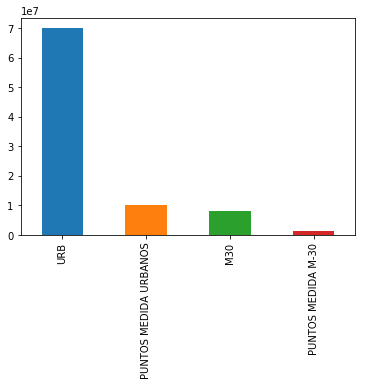

In [24]:
# Before applying the function. Histograms based on the categories.
df_complete['tipo_elem'].value_counts().plot(kind='bar')

In [25]:
%%time
df_complete['tipo_elem'] = df_complete['tipo_elem'].apply(tp_uniform)

CPU times: user 24 s, sys: 1.43 s, total: 25.4 s
Wall time: 25.7 s


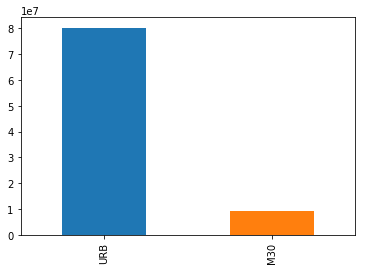

In [26]:
# After applying the function. Histograms based on the categories. 
df_complete['tipo_elem'].value_counts().plot(kind='bar')

There are some Measurement Points marked as *M30* type for some months and for another ones they are marked as *URB*. For these cases, we are going to mark them as *M30* for every month.

**- Dealing with wrong values**

*According to the data source:*

   *"En el caso de M30, si la velocidad media es “0” junto con el resto de datos es por ser un horario y una vía por la que no ha pasado ningún vehículo en ese periodo de tiempo. Sin embargo, si hay datos en intensidad u ocupación y la velocidad media es “0”, podría ser un error en la toma de datos por un fallo en el detector, un desfase horario o un fallo en el lazo electromagnético."*

   *"Para campos de vmed, intensidad y ocupación, si el valor es -1 implica la ausencia de datos. Podemos eliminar el registro correspondiente o imputarlo, con por ejemplo la media."*

In [27]:
%%time
condition=(df_complete['vmed'] == 0) & ((df_complete['intensidad']!=0) | (df_complete['ocupacion'] !=0))
df_complete_2=df_complete.drop(df_complete[condition].index)

CPU times: user 46 s, sys: 1min 39s, total: 2min 25s
Wall time: 3min 21s


In [28]:
%%time
df_complete_3=df_complete_2.drop(df_complete_2[df_complete_2['vmed']<0].index)

CPU times: user 4.5 s, sys: 8.45 s, total: 13 s
Wall time: 18.2 s


In a first approximation, we will drop these registers. Once we have a model for applying, we will want to improve it for example inputing them, between other actions.

In [29]:
df_complete_3.shape

(10274183, 13)

If we would have "intensidad", "ocupacion", "carga" or "vmed" taking negative values, it means that these are incorrect registers so we will drop it.

In [30]:
df_complete_3.describe()

,id,intensidad,ocupacion,carga,vmed,periodo_integracion,Lat,Long
count,1.027418e+07,1.027418e+07,1.027418e+07,1.027418e+07,1.027418e+07,1.027418e+07,1.027418e+07,1.027418e+07
mean,5.971502e+03,1.169725e+03,5.031878e+00,2.249205e+01,5.836161e+01,1.195411e+01,4.042927e+01,-3.692294e+00
std,2.272190e+03,1.328800e+03,7.013749e+00,2.753206e+01,2.789914e+01,4.609629e+00,3.692234e-02,3.423339e-02
min,1.001000e+03,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.033245e+01,-3.836943e+00
25%,4.746000e+03,1.560000e+02,0.000000e+00,0.000000e+00,4.600000e+01,5.000000e+00,4.039897e+01,-3.719845e+00
50%,6.733000e+03,6.570000e+02,3.000000e+00,8.000000e+00,6.500000e+01,1.500000e+01,4.041831e+01,-3.686571e+00
75%,6.868000e+03,1.788000e+03,7.000000e+00,4.100000e+01,7.900000e+01,1.500000e+01,4.046198e+01,-3.664111e+00
max,1.034300e+04,1.420800e+04,1.000000e+02,1.000000e+02,2.370000e+02,1.600000e+01,4.051561e+01,-3.580713e+00


In [31]:
%%time
df_complete_4=df_complete_3.drop(df_complete_3[df_complete_3['ocupacion']<0].index)

CPU times: user 3.69 s, sys: 6.12 s, total: 9.8 s
Wall time: 10.9 s


In [32]:
df_complete_4.shape

(10090919, 13)

Quick look to the features distribution and correlations.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1955fd30>,
      dtype=object)

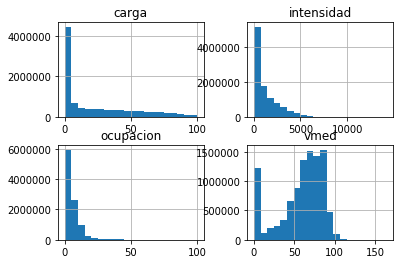

In [33]:
df_complete_4[['intensidad','ocupacion','vmed','carga']].hist(bins=20)

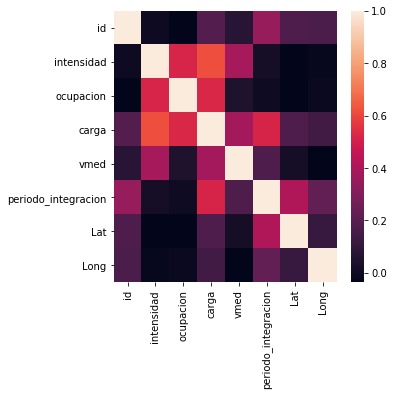

In [34]:
plt.figure(figsize=(5,5))
sns.heatmap(df_complete_4.corr())

**- Looking for Outliers**

- *Visual Approach*

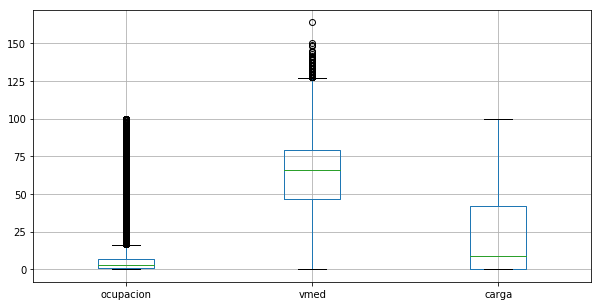

In [35]:
df_complete_4.boxplot(column=['ocupacion','vmed','carga'], grid=True, figsize=(10,5))

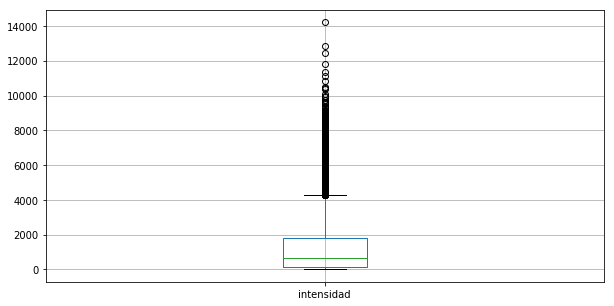

In [36]:
df_complete_4.boxplot(column=['intensidad'], grid=True, figsize=(10,5))

We can see some clear values that are out of range for 'vmed'. For 'intensidad' and 'ocupacion' there are a lot, but in this case it is not clear that these ones could be outliers. For now, we work with them.

- *Cuantitative Approach*

*The Z-score, or standard score, is a way of describing a data point in terms of its relationship to the mean and standard deviation of a group of points. Taking a Z-score is simply mapping the data onto a distribution whose mean is defined as 0 and whose standard deviation is defined as 1.*

*The goal of taking Z-scores is to remove the effects of the location and scale of the data, allowing different datasets to be compared directly. The intuition behind the Z-score method of outlier detection is that, once we’ve centred and rescaled the data, anything that is too far from zero (the threshold is usually a Z-score of 3 or -3) should be considered an outlier.*

Source: http://colingorrie.github.io/outlier-detection.html

In [37]:
%%time
#Copy the dataframe in other variable
df_complete_5=df_complete_4
#Iterate over the columns and create a new zscore column for Intensidad, Ocupacion, Carga y vmed.
for col in df_complete_5.columns:
    if col in ('vmed','carga','ocupacion','intensidad'):
        col_zscore = col + '_zscore'
        #Z-score:
        df_complete_5[col_zscore] = (df_complete_5[col] - df_complete_5[col].mean())/df_complete_5[col].std(ddof=0)

CPU times: user 815 ms, sys: 105 ms, total: 920 ms
Wall time: 416 ms


In [38]:
df_complete_5.dtypes

id                              int64
tipo_elem                      object
intensidad                      int64
ocupacion                       int64
carga                           int64
vmed                            int64
error                          object
periodo_integracion             int64
Fecha                          object
Hora                           object
Date                   datetime64[ns]
Lat                           float64
Long                          float64
intensidad_zscore             float64
ocupacion_zscore              float64
carga_zscore                  float64
vmed_zscore                   float64
dtype: object

Showing outliers from z-score computed column. A sample can be considered outliers when its value set out of the range [-3,3]

In [39]:
threshold=3
#Intensidad
i=df_complete_5[np.abs(df_complete_5['intensidad_zscore']) > threshold].shape[0]
print("-Intensidad Outliers according to its Zscore out of [-3,3] range: {}\n".format(i))
#Ocupacion
o=df_complete_5[np.abs(df_complete_5['ocupacion_zscore']) > threshold].shape[0]
print("-Ocupacion Outliers according to its Zscore out of [-3,3] range: {}\n".format(o))
#Intensidad
c=df_complete_5[np.abs(df_complete_5['carga_zscore']) > threshold].shape[0]
print("-Carga Outliers according to its Zscore out of [-3,3] range: {}\n".format(c))
#Intensidad
v=df_complete_5[np.abs(df_complete_5['vmed_zscore']) > threshold].shape[0]
print("-Vmed Outliers according to its Zscore out of [-3,3] range: {}".format(v))

-Intensidad Outliers according to its Zscore out of [-3,3] range: 147623

-Ocupacion Outliers according to its Zscore out of [-3,3] range: 213037

-Carga Outliers according to its Zscore out of [-3,3] range: 0

-Vmed Outliers according to its Zscore out of [-3,3] range: 8


**-One Hot Encoding for categorical features**

We have 2 categorical features: Tipo_elem and error

In [40]:
%%time
df1=pd.get_dummies(df_complete_5['tipo_elem'])
df2=pd.get_dummies(df_complete_5['error'])

CPU times: user 1.18 s, sys: 219 ms, total: 1.4 s
Wall time: 1.28 s


In [41]:
%time
df_complete_6=df_complete_5.merge(df1,left_index=True,right_index=True)
df_complete_6=df_complete_6.merge(df2,left_index=True,right_index=True)

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 9.06 µs


In [42]:
df_complete_6.head()

,id,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion,Fecha,Hora,Date,Lat,Long,intensidad_zscore,ocupacion_zscore,carga_zscore,vmed_zscore,M30,URB,N
0,1001,M30,204,12,0,73,N,5,2018-01-01,00:00:00,2018-01-01,40.409729,-3.740786,-0.739126,0.975690,-0.829367,0.517939,1,0,1
1,1002,M30,252,1,0,79,N,5,2018-01-01,00:00:00,2018-01-01,40.408029,-3.743760,-0.703113,-0.589153,-0.829367,0.732259,1,0,1
2,1003,M30,420,2,0,82,N,5,2018-01-01,00:00:00,2018-01-01,40.406824,-3.746834,-0.577067,-0.446894,-0.829367,0.839419,1,0,1
3,1006,M30,288,1,0,75,N,5,2018-01-01,00:00:00,2018-01-01,40.411894,-3.736324,-0.676103,-0.589153,-0.829367,0.589379,1,0,1
4,1009,M30,276,0,0,76,N,5,2018-01-01,00:00:00,2018-01-01,40.416233,-3.724909,-0.685106,-0.731411,-0.829367,0.625099,1,0,1


In [43]:
df_complete_6.dtypes

id                              int64
tipo_elem                      object
intensidad                      int64
ocupacion                       int64
carga                           int64
vmed                            int64
error                          object
periodo_integracion             int64
Fecha                          object
Hora                           object
Date                   datetime64[ns]
Lat                           float64
Long                          float64
intensidad_zscore             float64
ocupacion_zscore              float64
carga_zscore                  float64
vmed_zscore                   float64
M30                             uint8
URB                             uint8
N                               uint8
dtype: object

-------------

## **BREAK TO SAVE DATA FOR VISUALIZATIONS**

In [44]:
%%time
df_complete_6.to_csv('/Users/antoniobravomunoz/Documents/DATA_SCIENCE_MASTER/TFM/Data-Science-Master-project/DATA/traffic_data_complete_visualizations.csv',index=False)

CPU times: user 3min 57s, sys: 6.75 s, total: 4min 4s
Wall time: 4min 10s


-------------

**-Splitting and adapting Date feature in separated fields in order to adecuate data to Machine Learning Algorithm**

In [45]:
%%time
#Parsing Date feature to string in order to split it
df_complete_6['Date'] = df_complete_6['Date'].astype(str)

CPU times: user 14 s, sys: 752 ms, total: 14.8 s
Wall time: 14.7 s


In [46]:
type(df_complete_6['Date'][0])

str

In [47]:
%%time
df_complete_6['FechaAUX'], df_complete_6['HoraAUX'] = df_complete_6['Date'].str.split(' ', 1).str
df_complete_6['Anio'], df_complete_6['Mes'], df_complete_6['Dia'] = df_complete_6['FechaAUX'].str.split('-', 2).str
df_complete_6['Hora'], df_complete_6['Minutos'], df_complete_6['Segundos']= df_complete_6['HoraAUX'].str.split(':', 2).str

CPU times: user 2min 3s, sys: 10.9 s, total: 2min 14s
Wall time: 2min 14s


Dropping unusable columns including "Segundos" due to its value is always 00.

In [48]:
df_complete_6=df_complete_6.drop(['FechaAUX','HoraAUX','Date','Segundos'],axis=1)

Casting to integer date generated columns

In [49]:
df_complete_6 = df_complete_6.astype({"Anio": int, "Mes": int, "Dia": int, "Hora": int, "Minutos": int})

In [50]:
df_complete_6.dtypes

id                       int64
tipo_elem               object
intensidad               int64
ocupacion                int64
carga                    int64
vmed                     int64
error                   object
periodo_integracion      int64
Fecha                   object
Hora                     int64
Lat                    float64
Long                   float64
intensidad_zscore      float64
ocupacion_zscore       float64
carga_zscore           float64
vmed_zscore            float64
M30                      uint8
URB                      uint8
N                        uint8
Anio                     int64
Mes                      int64
Dia                      int64
Minutos                  int64
dtype: object

-**Cleaning-up the complete dataframe (Dropping auxiliar columns, original columns encoded, etc)**

In [51]:
final_df=df_complete_6.drop(columns=['tipo_elem','error','Fecha','intensidad_zscore','ocupacion_zscore',
                                     'carga_zscore','vmed_zscore'])

In [52]:
final_df.dtypes

id                       int64
intensidad               int64
ocupacion                int64
carga                    int64
vmed                     int64
periodo_integracion      int64
Hora                     int64
Lat                    float64
Long                   float64
M30                      uint8
URB                      uint8
N                        uint8
Anio                     int64
Mes                      int64
Dia                      int64
Minutos                  int64
dtype: object

In [53]:
final_df.shape

(10090919, 16)

Final dataframe correlation between features

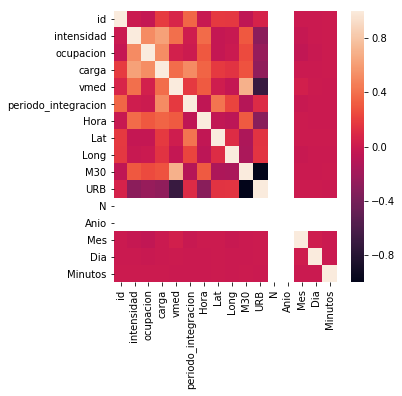

In [54]:
plt.figure(figsize=(5,5))
sns.heatmap(final_df.corr())

## **SAVING FINAL DATA**

Saving complete processed traffic data

In [55]:
%%time
final_df.to_csv('/Users/antoniobravomunoz/Documents/DATA_SCIENCE_MASTER/TFM/Data-Science-Master-project/DATA/traffic_data_complete.csv',index=False)

CPU times: user 3min 3s, sys: 3.63 s, total: 3min 6s
Wall time: 3min 9s
